In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import date, datetime, timezone
import os
import warnings

# import git
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import yaml

import pop_tools
import esmlab
import esmlab_regrid
print(esmlab_regrid.__version__) # Currently using ~/codes/esmlab_regrid (installed with pip -e from my fork)

from gen_remap_weights_1d import gen_remap_weights_1d
import config
import util

2019.5.2.dev11+gdc2c22d


In [3]:
# input specifications

tracernames = [ 'NOy_deposition', 'NHx_deposition']

# IC specified by OMIP (macronutrients, O2, DIC, ALK)
pop_ndep = '/glade/p/cesmdata/cseg/inputdata/ocn/pop/gx1v7/forcing/ndep_ocn_1850_w_nhx_emis_gx1v6_c180803.nc'


In [4]:
# details on file being generated

dst_grid = 'MOM_tx0.66v1'
ltripole = True
interp_method = 'bilinear'
datestamp = date.today().strftime("%y%m%d")
fname_out = f'{config.dirout}/ndep_ocn_1850_w_nhx_emis_{dst_grid}_c{datestamp}.nc'
print(fname_out)

/glade/work/mlevy/cesm_inputdata/ndep_ocn_1850_w_nhx_emis_MOM_tx0.66v1_c200827.nc


In [5]:
# start ds_out as Dataset of grid variables
ds_out = xr.open_dataset('/glade/p/cesmdata/cseg/mapping/grids/tx0.66v1_SCRIP_190314.nc')
ds_pop = xr.open_dataset(pop_ndep, decode_times=False)

ni, nj = ds_out.grid_dims.data

# Set up horizontal coords
ds_out.coords['LON'] = ('NLAT', 'NLON'), ds_out['grid_center_lon'].values.reshape(nj, ni)
ds_out.coords['LON'].attrs = ds_pop['TLONG'].attrs
ds_out.coords['LAT'] = ('NLAT', 'NLON'), ds_out['grid_center_lat'].values.reshape(nj, ni)
ds_out.coords['LAT'].attrs = ds_pop['TLAT'].attrs
ds_out.coords['time'] = ('time'), ds_pop['time']
ds_out.coords['time'].attrs = ds_pop['time'].attrs

print(f'ni = {ni}, nj = {nj}, and nk = nk')
ds_out

ni = 540, nj = 458, and nk = nk


<xarray.Dataset>
Dimensions:          (NLAT: 458, NLON: 540, grid_corners: 4, grid_rank: 2, grid_size: 247320, time: 12)
Coordinates:
    LON              (NLAT, NLON) float64 -286.7 -286.0 -285.3 ... 72.98 73.0
    LAT              (NLAT, NLON) float64 -79.2 -79.2 -79.2 ... 50.11 49.99
  * time             (time) float32 674899.0 674929.0 ... 675203.0 675233.0
Dimensions without coordinates: NLAT, NLON, grid_corners, grid_rank, grid_size
Data variables:
    grid_dims        (grid_rank) int32 540 458
    grid_center_lat  (grid_size) float64 -79.2 -79.2 -79.2 ... 50.27 50.11 49.99
    grid_center_lon  (grid_size) float64 -286.7 -286.0 -285.3 ... 72.98 73.0
    grid_imask       (grid_size) int32 ...
    grid_corner_lat  (grid_size, grid_corners) float64 ...
    grid_corner_lon  (grid_size, grid_corners) float64 ...
    grid_area        (grid_size) float64 ...
Attributes:
    date_created:  Thu Mar 14 14:15:56 MDT 2019
    Createdby:     ESMF_regridding.ncl
    Conventions:   SCRIP
    title:         tx0.66v1 Grid

In [6]:
# Add MOM6 grid to regrid settings (super kludgy!)

with open('MOM_grid.yaml') as gridfile:
    MOM6_regrid = yaml.safe_load(gridfile)
regrid_settings = esmlab.config.get('regrid')
regrid_settings['grids']['MOM_tx0.66v1'] = MOM6_regrid
esmlab.config.set({'regrid' : regrid_settings});

USER = os.environ['USER']

need to include NOy_deposition from /glade/p/cesmdata/cseg/inputdata/ocn/pop/gx1v7/forcing/ndep_ocn_1850_w_nhx_emis_gx1v6_c180803.nc


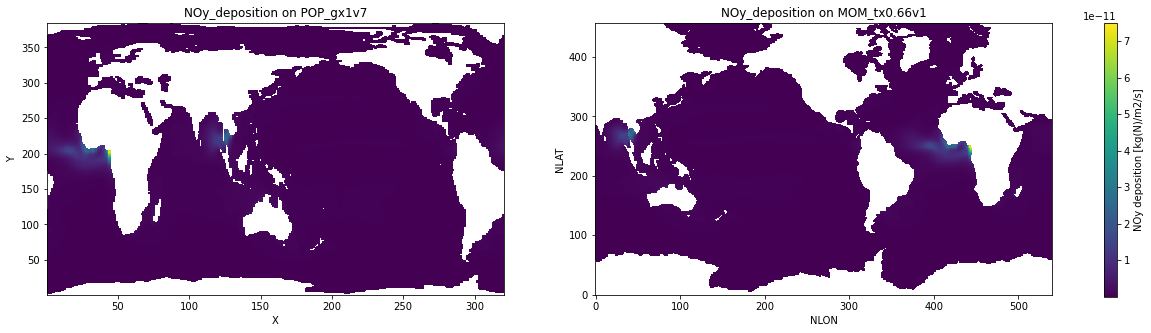


----

need to include NHx_deposition from /glade/p/cesmdata/cseg/inputdata/ocn/pop/gx1v7/forcing/ndep_ocn_1850_w_nhx_emis_gx1v6_c180803.nc


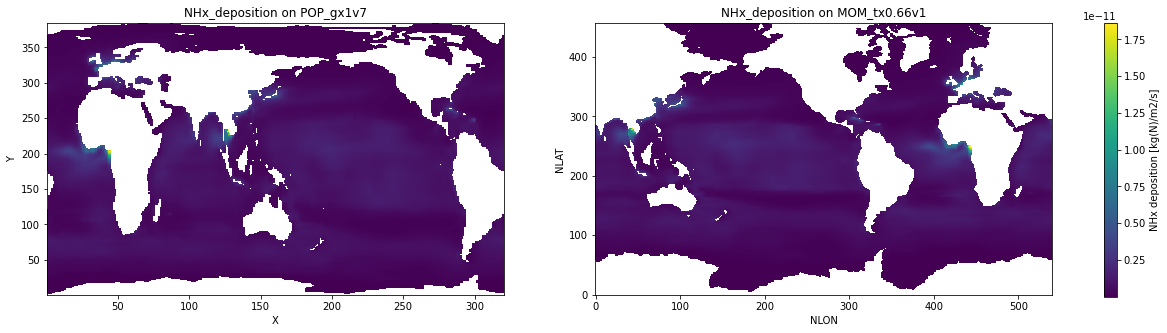


----

<xarray.Dataset>
Dimensions:          (NLAT: 458, NLON: 540, grid_corners: 4, grid_rank: 2, grid_size: 247320, time: 12)
Coordinates:
    LON              (NLAT, NLON) float64 -286.7 -286.0 -285.3 ... 72.98 73.0
    LAT              (NLAT, NLON) float64 -79.2 -79.2 -79.2 ... 50.11 49.99
  * time             (time) float32 674899.0 674929.0 ... 675203.0 675233.0
Dimensions without coordinates: NLAT, NLON, grid_corners, grid_rank, grid_size
Data variables:
    grid_dims        (grid_rank) int32 540 458
    grid_center_lat  (grid_size) float64 -79.2 -79.2 -79.2 ... 50.27 50.11 49.99
    grid_center_lon  (grid_size) float64 -286.7 -286.0 -285.3 ... 72.98 73.0
    grid_imask       (grid_size) int32 ...
    grid_corner_lat  (grid_size, grid_corners) float64 ...
    grid_corner_lon  (grid_size, grid_corners) float64 ...
    grid_area        (grid_size) float64 ...
    NOy_deposition   (time, NLAT, NLON) float64 nan nan nan nan ... nan nan nan
    NHx_deposition   (time, NLAT, NLON) flo

In [7]:
%%time
# map tracers not yet in ds_out from refcase restart file to ds_out
fillvalue = -1.0e34 # value to replace land values with

src_grid = 'POP_gx1v7'
MASK = xr.where(ds_pop['KMT']>0, True, False)
for tracername in tracernames:
    if tracername not in ds_out.data_vars:
        print(f'need to include {tracername} from {pop_ndep}')
        tracer = ds_pop[tracername]
        time_in = tracer.shape[0]
        tracer.encoding['_FillValue'] = fillvalue

        # Plot on src grid
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18.0, 5.0))
        plt.subplot(121)
        tracer.isel(time=0).plot(add_colorbar=False)
        plt.title(f"{tracername} on {src_grid}")

        # perform lateral remapping
        regrid_operator = esmlab_regrid.regridder(
            name_grid_src=src_grid, name_grid_dst=dst_grid,
            method=interp_method, overwrite_existing=False)
        MOM_MASK = regrid_operator(MASK, renormalize=True).rename({'Y': 'NLAT', 'X' : 'NLON'})
        tracer_lateral_regrid = regrid_operator(tracer, renormalize=True)
        tracer_full_regrid = xr.DataArray(tracer_lateral_regrid, dims=('time', 'NLAT', 'NLON'),
                                          coords={'time':ds_out.time}, attrs=tracer.attrs)
        tracer_full_regrid = tracer_full_regrid.where(MOM_MASK)
#         tracer_full_regrid = pop_tools.lateral_fill(tracer_full_regrid, MOM_MASK, ltripole=ltripole)
        ds_out[tracername] = tracer_full_regrid

        plt.subplot(122)
        my_plot = ds_out[tracername].isel(time=0).plot(add_colorbar=False)
        plt.title(f'{tracername} on {dst_grid}')
        cax = plt.axes((0.94, 0.12, 0.01, 0.76))
        cbar = fig.colorbar(my_plot, ax=axes.ravel().tolist(), cax=cax)
        cbar.set_label('{} [{}]'.format(tracer.attrs['long_name'],
                                        tracer.attrs['units']),
                                        rotation=90)
        plt.show()
        print('\n----\n')
        plt.show()

print(ds_out)

In [8]:
if 'grid_dims' in ds_out.variables:
    ds_out = ds_out.drop(['grid_dims', 'grid_center_lat', 'grid_center_lon', 'grid_corner_lat', 'grid_corner_lon', 'grid_imask', 'grid_area'])
ds_out

<xarray.Dataset>
Dimensions:         (NLAT: 458, NLON: 540, time: 12)
Coordinates:
    LON             (NLAT, NLON) float64 -286.7 -286.0 -285.3 ... 72.98 73.0
    LAT             (NLAT, NLON) float64 -79.2 -79.2 -79.2 ... 50.27 50.11 49.99
  * time            (time) float32 674899.0 674929.0 ... 675203.0 675233.0
Dimensions without coordinates: NLAT, NLON
Data variables:
    NOy_deposition  (time, NLAT, NLON) float64 nan nan nan nan ... nan nan nan
    NHx_deposition  (time, NLAT, NLON) float64 nan nan nan nan ... nan nan nan
Attributes:
    date_created:  Thu Mar 14 14:15:56 MDT 2019
    Createdby:     ESMF_regridding.ncl
    Conventions:   SCRIP
    title:         tx0.66v1 Grid

In [11]:
# write generated file

datestamp = datetime.now(timezone.utc).strftime("%Y-%m-%d")
ds_out.attrs['history'] = f'created by {USER} on {datestamp}'
util.ds_clean(ds_out).to_netcdf(fname_out)
print(f'created {fname_out}')

created /glade/work/mlevy/cesm_inputdata/ndep_ocn_1850_w_nhx_emis_MOM_tx0.66v1_c200827.nc
